In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import seaborn as sns

Let get the mean CP values over all units in the IC and CN for each tone duration. We also need to split units into eithier an increasing or decreasing group for plotting. 

In [2]:
CP_data_1 = sp.io.loadmat('../TIN_CP_data/1-46_CP_data.mat')
CP_data_2 = sp.io.loadmat('../TIN_CP_data/51-100_CP_data.mat')
CP_data_3 = sp.io.loadmat('../TIN_CP_data/101-166_CP_data.mat')
CP_data_4 = sp.io.loadmat('../TIN_CP_data/168-178_CP_data.mat')

In [3]:
Grand_CP_1 = CP_data_1.get('Grand_CP')
Grand_CP_2 = CP_data_2.get('Grand_CP')
Grand_CP_3 = CP_data_3.get('Grand_CP')
Grand_CP_4 = CP_data_4.get('Grand_CP')

In [4]:
p_values_1 = CP_data_1.get('p_values')
p_values_2 = CP_data_2.get('p_values')
p_values_3 = CP_data_3.get('p_values')
p_values_4 = CP_data_4.get('p_values')


In [5]:
# Initial Split and concat grand cp values into seperate IC and CN df's
# column 16 (index 15) is the 200 ms condition 
# Group 1 -- 1- 46 is all IC ,  
# Group 2 --  51 - 100 is all IC , 
# Group 3 --  101-166 is first 2 IC and the rest CN,
# Group 4 --  168-178 is all CN
IC_Grand_CP = np.concatenate((Grand_CP_1,
                              Grand_CP_2,
                              Grand_CP_3[0:2,:]), axis=0)
CN_Grand_CP = np.concatenate((Grand_CP_3[2:, :],
                              Grand_CP_4), axis=0)

In [6]:
IC_p_values = np.concatenate((p_values_1,
                              p_values_2,
                              p_values_3[0:2,:]), axis=0)
CN_p_values = np.concatenate((p_values_3[2:, :],
                              p_values_4), axis=0)

In [7]:
def matlab_cleaner(matlab_cell):
    value_list = []
    for col in range(0, len(matlab_cell[0,:])):

        col_list = []
        for row in range(0,len(matlab_cell[:,col])):
            if (type(matlab_cell[:,col][row][0]) == np.ndarray) & (len(matlab_cell[:,col][row][0]) > 0):
                value = matlab_cell[:,col][row][0,0]   
            else:
                value = matlab_cell[:,col][row][0]

            col_list.append(value)
            
        value_list.insert(col, col_list)
    return(value_list)

In [8]:
IC_CP_value_list = matlab_cleaner(IC_Grand_CP)
CN_CP_value_list = matlab_cleaner(CN_Grand_CP)

filter out units that dont have significance, ie are > .001

In [9]:
IC_p_values_list = matlab_cleaner(IC_p_values)
CN_p_values_list = matlab_cleaner(CN_p_values)

In [10]:
IC_p_values_df = pd.DataFrame(IC_p_values_list).replace(to_replace='NA', value=np.nan)
CN_p_values_df = pd.DataFrame(CN_p_values_list).replace(to_replace='NA', value=np.nan)

IC_df = pd.DataFrame(IC_CP_value_list).replace(to_replace='NA', value=np.nan)
CN_df = pd.DataFrame(CN_CP_value_list).replace(to_replace='NA', value=np.nan)

c:\Users\jacks\anaconda3\lib\site-packages\pandas\core\missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x


In [11]:
IC_df = IC_df[IC_p_values_df < .1].dropna(axis=1, how='all')
CN_df = CN_df[CN_p_values_df < .1].dropna(axis=1, how='all')

In [12]:
#Exlcude the 12.5, 25, 37.5 durations from the analysis. the first 3 rows
#Add first row for 0 duration, all columns = 0.5 
IC_df = IC_df.loc[3:]
new_row_IC = pd.DataFrame([[0.5]*len(IC_df.columns)], columns=IC_df.columns)
IC_df = pd.concat([new_row_IC, IC_df]).reset_index(drop=True)

CN_df = CN_df.loc[3:]
new_row_CN = pd.DataFrame([[0.5]*len(CN_df.columns)], columns=CN_df.columns)
CN_df = pd.concat([new_row_CN, CN_df]).reset_index(drop=True)

In [16]:
# Now split the IC and CN into increasing or decreasing units(columns) and then take the means of each tone (rows)

def unit_splitter(df):

    moreidx = [col for col in df.columns if df[col].iloc[13] > 0.5]
    lessidx = [col for col in df.columns if df[col].iloc[13] < 0.5]

    # Create new dataframes with increasing and decreasing columns
    df_increasing = df[moreidx]
    df_decreasing = df[lessidx]

    return df_increasing, df_decreasing

In [17]:
# Now split the IC and CN into increasing or decreasing units(columns) and then take the means of each tone (rows)
IC_df_increasing, IC_df_decreasing = unit_splitter(IC_df)
CN_df_increasing, CN_df_decreasing = unit_splitter(CN_df)


In [18]:
from scipy import stats
import matplotlib.pyplot as plt

In [19]:
IC_inc_yvals = IC_df_increasing.mean(axis=1, numeric_only=True)
IC_inc_SE = stats.sem(IC_df_increasing, axis=1)

IC_dec_yvals = IC_df_decreasing.mean(axis=1, numeric_only=True)
IC_dec_SE = stats.sem(IC_df_decreasing, axis=1)

CN_inc_yvals = CN_df_increasing.mean(axis=1, numeric_only=True)
CN_inc_SE = stats.sem(CN_df_increasing, axis=1)

CN_dec_yvals = CN_df_decreasing.mean(axis=1, numeric_only=True)
CN_dec_SE = stats.sem(CN_df_decreasing, axis=1)

In [20]:
arr = np.arange(0,212.5, 12.5)
arr = arr[(arr < 12.5) | (arr > 37.5)]

tone_levels = pd.DataFrame(arr)

In [21]:
IC_graph_data = pd.concat([tone_levels, IC_inc_yvals, IC_dec_yvals], axis=1)
IC_graph_data.columns = ['tone_levels','Increasing', 'Decreasing']
IC_graph_data = IC_graph_data.set_index('tone_levels')

In [22]:
CN_graph_data = pd.concat([tone_levels, CN_inc_yvals, CN_dec_yvals], axis=1)
CN_graph_data.columns = ['tone_levels','Increasing', 'Decreasing']
CN_graph_data = CN_graph_data.set_index('tone_levels')

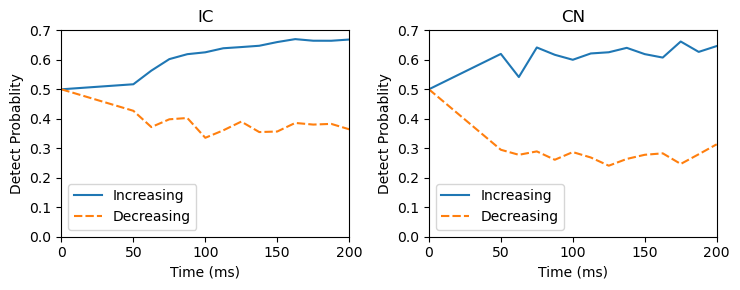

In [23]:
# 2 graphs IC, CN - both have increasing and decreasing mean lines with +-SE lines around them

plt.rcParams["figure.figsize"] = [7.50, 3.0]
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(1, 2)
axes[0].set_xlim([0,200])
axes[0].set_ylim([0,.7])
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Detect Probablity')
axes[1].set_xlim([0,200])
axes[1].set_ylim([0,.7])
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Detect Probablity')

# IC Lines
axes[0].set_title('IC')
sns.lineplot(ax = axes[0],
             data = IC_graph_data
            )



# CN Histogram
axes[1].set_title('CN')
sns.lineplot(ax = axes[1],
             data = CN_graph_data
            )

plt.show()  